# DB2 Data Cleaning

SInce the large scale of the datas, selecting 10 times enteries of the number of features.  Experiment 1- 9

### framework.csv

# 1. Importing the Data from the Datasets and make one Dataset for training

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Table types and information.

In [2]:
tables = {
    'Table name': ["LINEITEM1", "GIGANTICORDERS", "ORDERS2", "ORDERS3", "ORDERS4", "ORDERS5", "ORDERS6", "ORDERS7", "ORDERS8", "ORDERS10", "ORDERSWIDE2"],
    'Data size(MB)': [674, 5477, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 275, 5337],
    'number of rows': [3894493, 45000000, 15000000, 15000000, 15000000, 15000000, 15000000, 15000000,  15000000, 1993416, 15000000],
    'number of columns': [16, 9, 9, 9, 9, 9, 9, 9, 9, 9, 27]
    }

tables_df = pd.DataFrame(tables)

In [3]:
tables_df.head()

,Table name,Data size(MB),number of rows,number of columns
0,LINEITEM1,674,3894493,16
1,GIGANTICORDERS,5477,45000000,9
2,ORDERS2,1825,15000000,9
3,ORDERS3,1825,15000000,9
4,ORDERS4,1825,15000000,9


In [4]:
source_machine_specs = {
    'RAM (GB)': [120],
    'CPU': [16],
    'Disk (GB)': [20],
    'External Disk (GB)': [576]
    }

source_machine_df = pd.DataFrame(source_machine_specs)

In [5]:
source_machine_df.head()

,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,120,16,20,576


In [6]:
exp1_framework_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp1\\framework.csv')
exp2_framework_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp2\\framework.csv')
exp3_framework_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp3\\framework.csv')
exp4_framework_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp4\\framework.csv')
exp5_framework_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp5\\framework.csv')
exp6_framework_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp6\\framework.csv')
exp7_framework_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp7\\framework.csv')
exp8_framework_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp8\\framework.csv')
exp9_framework_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp9 + error\\framework.csv')


In [7]:
exp1_framework_df.head()

,Experiment Number,file,limit,compressionType,stream,Experiment startTime,logType,operation,statusOfOperation,timestamp
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,info,Experiment,started,1.717525e+09
1,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,info,Experiment,completed,1.717528e+09
2,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,info,Experiment,started,1.717528e+09
3,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,info,Experiment,completed,1.717529e+09
4,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,info,Experiment,started,1.717529e+09


In [8]:
exp1_framework_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Experiment Number     10 non-null     int64  
 1   file                  10 non-null     object 
 2   limit                 10 non-null     object 
 3   compressionType       10 non-null     object 
 4   stream                10 non-null     int64  
 5   Experiment startTime  10 non-null     bool   
 6   logType               10 non-null     object 
 7   operation             10 non-null     object 
 8   statusOfOperation     10 non-null     object 
 9   timestamp             10 non-null     float64
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 862.0+ bytes


In [9]:
exp9_framework_df.head(10)

,Experiment Number,file,limit,compressionType,stream,Experiment startTime,logType,operation,statusOfOperation,timestamp
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,started,1.717994e+09
1,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,completed,1.717994e+09
2,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,started,1.717994e+09
3,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,completed,1.717995e+09
4,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,started,1.717995e+09
5,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,completed,1.717995e+09
6,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,started,1.717995e+09
7,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,completed,1.717995e+09
8,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,started,1.717995e+09
9,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,completed,1.717996e+09


In [10]:
exp9_framework_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Experiment Number     49 non-null     int64  
 1   file                  49 non-null     object 
 2   limit                 49 non-null     object 
 3   compressionType       49 non-null     object 
 4   stream                49 non-null     int64  
 5   Experiment startTime  49 non-null     bool   
 6   logType               49 non-null     object 
 7   operation             49 non-null     object 
 8   statusOfOperation     49 non-null     object 
 9   timestamp             49 non-null     float64
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 3.6+ KB


In [11]:
# framework_1_9 = pd.concat([exp1_df, exp2_df, exp3_df, exp4_df, exp5_df, exp6_df, exp7_df, exp8_df, exp9_df], ignore_index= True, sort= False)
# framework_1_9.head(30)

In [12]:
def framework_cleaning(df, experiment_number):
    # Split the dataframe into started and completed dataframes
    started_df = df[df['statusOfOperation'] == 'started']
    completed_df = df[df['statusOfOperation'] == 'completed']

    # Merge the dataframes on the common columns
    merged_df = pd.merge(
        started_df,
        completed_df,
        on=['Experiment Number', 'file', 'limit', 'compressionType', 'stream', 'Experiment startTime', 'logType', 'operation'],
        suffixes=('_start', '_end')
    )

    # Rename the timestamp columns
    merged_df.rename(columns={
        'timestamp_start': 'Experiment StartTime Framework',
        'timestamp_end': 'Experiment EndTime Framework'
    }, inplace=True)

    # Select the relevant columns for the final dataframe
    final_df = merged_df[[
        'Experiment Number', 'file', 'limit', 'compressionType', 'stream', 'Experiment startTime', 'logType', 'operation',
        'Experiment StartTime Framework', 'Experiment EndTime Framework'
    ]]

    final_df.insert(0, "Experiment", experiment_number)

    return final_df

In [13]:
exp1_final_framework_df = framework_cleaning(exp1_framework_df, 1)
exp2_final_framework_df = framework_cleaning(exp2_framework_df, 2)
exp3_final_framework_df = framework_cleaning(exp3_framework_df, 3)
exp4_final_framework_df = framework_cleaning(exp4_framework_df, 4)
exp5_final_framework_df = framework_cleaning(exp5_framework_df, 5)
exp6_final_framework_df = framework_cleaning(exp6_framework_df, 6)
exp7_final_framework_df = framework_cleaning(exp7_framework_df, 7)
exp8_final_framework_df = framework_cleaning(exp8_framework_df, 8)
exp9_final_framework_df = framework_cleaning(exp9_framework_df, 9)


In [14]:
exp1_final_framework_df.head()

,Experiment,Experiment Number,file,limit,compressionType,stream,Experiment startTime,logType,operation,Experiment StartTime Framework,Experiment EndTime Framework
0,1,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,info,Experiment,1.717525e+09,1.717528e+09
1,1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,info,Experiment,1.717528e+09,1.717529e+09
2,1,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,info,Experiment,1.717529e+09,1.717531e+09
3,1,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,info,Experiment,1.717531e+09,1.717535e+09
4,1,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,info,Experiment,1.717535e+09,1.717537e+09


In [15]:
exp9_final_framework_df.head(10)

,Experiment,Experiment Number,file,limit,compressionType,stream,Experiment startTime,logType,operation,Experiment StartTime Framework,Experiment EndTime Framework
0,9,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,1.717994e+09,1.717994e+09
1,9,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,1.717994e+09,1.717995e+09
2,9,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,1.717995e+09,1.717995e+09
3,9,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,1.717995e+09,1.717995e+09
4,9,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,10,False,info,Experiment,1.717995e+09,1.717996e+09
5,9,1,NO,testdb_testdb,GIGANTICORDERS,10,False,info,Experiment,1.717996e+09,1.717996e+09
6,9,2,NO,testdb_testdb,GIGANTICORDERS,10,False,info,Experiment,1.717996e+09,1.717997e+09
7,9,3,NO,testdb_testdb,GIGANTICORDERS,10,False,info,Experiment,1.717997e+09,1.717998e+09
8,9,4,NO,testdb_testdb,GIGANTICORDERS,10,False,info,Experiment,1.717998e+09,1.717998e+09
9,9,5,NO,testdb_testdb,GIGANTICORDERS,10,False,info,Experiment,1.717998e+09,1.717999e+09


## performanceBenchmark.csv

In [16]:
exp1_performance_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp1\\performanceBenchmark.csv')
exp2_performance_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp2\\performanceBenchmark.csv')
exp3_performance_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp3\\performanceBenchmark.csv')
exp4_performance_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp4\\performanceBenchmark.csv')
exp5_performance_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp5\\performanceBenchmark.csv')
exp6_performance_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp6\\performanceBenchmark.csv')
exp7_performance_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp7\\performanceBenchmark.csv')
exp8_performance_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp8\\performanceBenchmark.csv')
exp9_performance_df = pd.read_csv('F:\\OneDrive_2024-06-29\\Thesis results\\exp9 + error\\performanceBenchmark.csv')

In [17]:
exp1_performance_df.head()

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3296.018193,3266.620216,32.906244,NaN
1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,622.369466,588.320576,3.208371,NaN
2,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1945.972293,1920.935266,3.742569,NaN
3,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3834.102760,3783.924402,6.611556,NaN
4,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1933.460342,1901.642637,6.197286,NaN


In [18]:
def performance_cleaning(df, experiment_number):

    # Create a copy of the dataframe
    final_df = df.copy()

    # Insert the experiment number column
    final_df.insert(0, "Experiment", experiment_number)

    # Rename the startTime columns
    final_df.rename(columns={
        'Experiment startTime': 'Experiment startTime Performance',
    }, inplace=True)

    return final_df


In [19]:
exp1_final_performance_df = performance_cleaning(exp1_performance_df, 1)
exp2_final_performance_df = performance_cleaning(exp2_performance_df, 2)
exp3_final_performance_df = performance_cleaning(exp3_performance_df, 3)
exp4_final_performance_df = performance_cleaning(exp4_performance_df, 4)
exp5_final_performance_df = performance_cleaning(exp5_performance_df, 5)
exp6_final_performance_df = performance_cleaning(exp6_performance_df, 6)
exp7_final_performance_df = performance_cleaning(exp7_performance_df, 7)
exp8_final_performance_df = performance_cleaning(exp8_performance_df, 8)
exp9_final_performance_df = performance_cleaning(exp9_performance_df, 9)

Concatenating all the experiments

In [20]:
performance_dfs = [exp1_final_performance_df, exp2_final_performance_df, exp3_final_performance_df, 
                   exp4_final_performance_df, exp5_final_performance_df, exp6_final_performance_df, 
                   exp7_final_performance_df, exp8_final_performance_df, exp9_final_performance_df]

performance_df = pd.concat(performance_dfs, ignore_index=True)

In [21]:
performance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Experiment                        140 non-null    int64  
 1   Experiment Number                 140 non-null    int64  
 2   compress                          140 non-null    object 
 3   sourceDatabasetoTargetDatabase    140 non-null    object 
 4   tables                            140 non-null    object 
 5   maxStreams                        140 non-null    int64  
 6   binary                            140 non-null    bool   
 7   Experiment startTime Performance  140 non-null    float64
 8   TotalExperimentTime               140 non-null    float64
 9   TotaltransferTime                 140 non-null    float64
 10  totalPrecheckTime                 140 non-null    float64
 11  TotalClearTime                    97 non-null     float64
dtypes: bool(

In [22]:
exp1_final_performance_df.head()

,Experiment,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime Performance,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
0,1,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3296.018193,3266.620216,32.906244,NaN
1,1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,622.369466,588.320576,3.208371,NaN
2,1,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1945.972293,1920.935266,3.742569,NaN
3,1,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3834.102760,3783.924402,6.611556,NaN
4,1,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1933.460342,1901.642637,6.197286,NaN


In [23]:
exp2_final_performance_df.head()

,Experiment,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime Performance,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
0,2,1,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717540e+09,973.996680,928.459119,6.801755,NaN
1,2,2,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717540e+09,4885.505116,4838.436518,5.467048,NaN
2,2,3,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717540e+09,3420.717717,3387.124010,4.323738,NaN
3,2,4,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717540e+09,2499.214914,2479.712331,4.170232,NaN
4,2,5,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717540e+09,2435.252487,2414.547340,4.627977,NaN


In [24]:
# df_merged = pd.merge()

In [25]:
# Split the table names
table_names = exp1_final_performance_df['tables'].str.split('_', expand=False)
print(table_names)

0    [LINEITEM1, ORDERS2, ORDERS10]
1    [LINEITEM1, ORDERS2, ORDERS10]
2    [LINEITEM1, ORDERS2, ORDERS10]
3    [LINEITEM1, ORDERS2, ORDERS10]
4    [LINEITEM1, ORDERS2, ORDERS10]
Name: tables, dtype: object


The `calculate_table_sums` function calculates and aggregates the total data size, number of rows, and number of columns for specified table names within a dataframe. It adds these aggregated values as new features to the original dataframe.

In [26]:
def calculate_table_sums(exp_df, tables_df):

    # Extract table names
    table_names_series = exp_df['tables'].str.split('_', expand=False)
    
    # Initialize lists to store the sums
    data_size_sum = []
    rows_sum = []
    columns_sum = []
    print(data_size_sum, rows_sum, columns_sum)

    # Iterate over each row of table names
    for table_names in table_names_series:
        # Filter the info dataframe for the current table names
        filtered_info = tables_df[tables_df['Table name'].isin(table_names)]
        # print(filtered_info)
        # Calculate the sums
        data_size_sum.append(filtered_info['Data size(MB)'].sum())
        rows_sum.append(filtered_info['number of rows'].sum())
        columns_sum.append(filtered_info['number of columns'].sum())
        # print(data_size_sum, rows_sum, columns_sum)


    # Add the sums as new features in the initial dataframe
    exp_df['Data size sum (MB)'] = data_size_sum
    exp_df['Number of rows sum'] = rows_sum
    exp_df['Number of columns sum'] = columns_sum

    
    exp_df = exp_df[['Experiment', 'Experiment Number', 'compress', 'sourceDatabasetoTargetDatabase', 'tables', 'Data size sum (MB)', 'Number of rows sum', 'Number of columns sum', 'maxStreams', 'binary', 'Experiment startTime Performance', 'TotalExperimentTime', 'TotaltransferTime', 'totalPrecheckTime', 'TotalClearTime']]

    return exp_df

In [27]:
performance_df = calculate_table_sums(performance_df, tables_df)

[] [] []


In [28]:
performance_df.head(10)

,Experiment,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,Experiment startTime Performance,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
0,1,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717525e+09,3296.018193,3266.620216,32.906244,NaN
1,1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717525e+09,622.369466,588.320576,3.208371,NaN
2,1,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717525e+09,1945.972293,1920.935266,3.742569,NaN
3,1,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717525e+09,3834.102760,3783.924402,6.611556,NaN
4,1,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717525e+09,1933.460342,1901.642637,6.197286,NaN
5,2,1,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717540e+09,973.996680,928.459119,6.801755,NaN
6,2,2,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717540e+09,4885.505116,4838.436518,5.467048,NaN
7,2,3,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717540e+09,3420.717717,3387.124010,4.323738,NaN
8,2,4,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717540e+09,2499.214914,2479.712331,4.170232,NaN
9,2,5,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717540e+09,2435.252487,2414.547340,4.627977,NaN


In [29]:
# exp1_final_performance_df = calculate_table_sums(exp1_final_performance_df, tables_df)
# exp2_final_performance_df = calculate_table_sums(exp2_final_performance_df, tables_df)
# exp3_final_performance_df = calculate_table_sums(exp3_final_performance_df, tables_df)
# exp4_final_performance_df = calculate_table_sums(exp4_final_performance_df, tables_df)
# exp5_final_performance_df = calculate_table_sums(exp5_final_performance_df, tables_df)
# exp6_final_performance_df = calculate_table_sums(exp6_final_performance_df, tables_df)
# exp7_final_performance_df = calculate_table_sums(exp7_final_performance_df, tables_df)
# exp8_final_performance_df = calculate_table_sums(exp8_final_performance_df, tables_df)
# exp9_final_performance_df = calculate_table_sums(exp9_final_performance_df, tables_df)



In [30]:
# exp9_final_performance_df.head(10)

In [31]:
# Concatenate the experiment tables with the system specs
df2_repeated = pd.concat([source_machine_df]*len(performance_df), ignore_index=True)


result_df = pd.concat([performance_df, df2_repeated], axis=1)


In [32]:
result_df.head()

,Experiment,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,Experiment startTime Performance,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,1,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717525e+09,3296.018193,3266.620216,32.906244,NaN,120,16,20,576
1,1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717525e+09,622.369466,588.320576,3.208371,NaN,120,16,20,576
2,1,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717525e+09,1945.972293,1920.935266,3.742569,NaN,120,16,20,576
3,1,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717525e+09,3834.102760,3783.924402,6.611556,NaN,120,16,20,576
4,1,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,1,False,1.717525e+09,1933.460342,1901.642637,6.197286,NaN,120,16,20,576


In [33]:
print(type(result_df))


<class 'pandas.core.frame.DataFrame'>


In [34]:
result_df.drop(labels=['Experiment', 'Experiment Number', 'sourceDatabasetoTargetDatabase', 'tables', 'TotalExperimentTime', 'totalPrecheckTime', 'TotalClearTime'], axis=1, inplace=True)

In [35]:
result_df.head(10)

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,Experiment startTime Performance,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,NO,2774,20887909,34,1,False,1.717525e+09,3266.620216,120,16,20,576
1,NO,2774,20887909,34,1,False,1.717525e+09,588.320576,120,16,20,576
2,NO,2774,20887909,34,1,False,1.717525e+09,1920.935266,120,16,20,576
3,NO,2774,20887909,34,1,False,1.717525e+09,3783.924402,120,16,20,576
4,NO,2774,20887909,34,1,False,1.717525e+09,1901.642637,120,16,20,576
5,GZIP,2774,20887909,34,1,False,1.717540e+09,928.459119,120,16,20,576
6,GZIP,2774,20887909,34,1,False,1.717540e+09,4838.436518,120,16,20,576
7,GZIP,2774,20887909,34,1,False,1.717540e+09,3387.124010,120,16,20,576
8,GZIP,2774,20887909,34,1,False,1.717540e+09,2479.712331,120,16,20,576
9,GZIP,2774,20887909,34,1,False,1.717540e+09,2414.547340,120,16,20,576


# 2. Data Cleaning

### 2.1 Check for duplicate rows and remove them if any.

In [36]:
result_df.duplicated().sum()

3

In [37]:
result_df.drop_duplicates()

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,Experiment startTime Performance,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,NO,2774,20887909,34,1,False,1.717525e+09,3266.620216,120,16,20,576
1,NO,2774,20887909,34,1,False,1.717525e+09,588.320576,120,16,20,576
2,NO,2774,20887909,34,1,False,1.717525e+09,1920.935266,120,16,20,576
3,NO,2774,20887909,34,1,False,1.717525e+09,3783.924402,120,16,20,576
4,NO,2774,20887909,34,1,False,1.717525e+09,1901.642637,120,16,20,576
...,...,...,...,...,...,...,...,...,...,...,...,...
132,NO,5337,15000000,27,10,False,1.718020e+09,320.256194,120,16,20,576
133,NO,5337,15000000,27,10,False,1.718020e+09,308.434418,120,16,20,576
134,NO,5337,15000000,27,10,False,1.718020e+09,322.706327,120,16,20,576
135,NO,23589,165000000,99,10,False,1.718023e+09,11094.895988,120,16,20,576


### 2.2 Handle the missing values

In [38]:
result_df.isna().sum()

compress                            0
Data size sum (MB)                  0
Number of rows sum                  0
Number of columns sum               0
maxStreams                          0
binary                              0
Experiment startTime Performance    0
TotaltransferTime                   0
RAM (GB)                            0
CPU                                 0
Disk (GB)                           0
External Disk (GB)                  0
dtype: int64

The "TotalClearTime" is part of the "TotalTransferTime". The NaN values will be replaced with zero.

In [39]:
# result_df['TotalClearTime'] = result_df['TotalClearTime'].replace(np.nan, 0)


In [40]:
result_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,Experiment startTime Performance,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,NO,2774,20887909,34,1,False,1.717525e+09,3266.620216,120,16,20,576
1,NO,2774,20887909,34,1,False,1.717525e+09,588.320576,120,16,20,576
2,NO,2774,20887909,34,1,False,1.717525e+09,1920.935266,120,16,20,576
3,NO,2774,20887909,34,1,False,1.717525e+09,3783.924402,120,16,20,576
4,NO,2774,20887909,34,1,False,1.717525e+09,1901.642637,120,16,20,576
...,...,...,...,...,...,...,...,...,...,...,...,...
135,NO,23589,165000000,99,10,False,1.718023e+09,11094.895988,120,16,20,576
136,NO,23589,165000000,99,10,False,1.718023e+09,0.000000,120,16,20,576
137,NO,23589,165000000,99,10,False,1.718023e+09,0.000000,120,16,20,576
138,NO,23589,165000000,99,10,False,1.718023e+09,0.000000,120,16,20,576


In [41]:
result_df = result_df.drop(result_df[result_df['TotaltransferTime'] == 0].index)


In [42]:
result_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,Experiment startTime Performance,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,NO,2774,20887909,34,1,False,1.717525e+09,3266.620216,120,16,20,576
1,NO,2774,20887909,34,1,False,1.717525e+09,588.320576,120,16,20,576
2,NO,2774,20887909,34,1,False,1.717525e+09,1920.935266,120,16,20,576
3,NO,2774,20887909,34,1,False,1.717525e+09,3783.924402,120,16,20,576
4,NO,2774,20887909,34,1,False,1.717525e+09,1901.642637,120,16,20,576
...,...,...,...,...,...,...,...,...,...,...,...,...
131,NO,5337,15000000,27,10,False,1.718020e+09,259.839403,120,16,20,576
132,NO,5337,15000000,27,10,False,1.718020e+09,320.256194,120,16,20,576
133,NO,5337,15000000,27,10,False,1.718020e+09,308.434418,120,16,20,576
134,NO,5337,15000000,27,10,False,1.718020e+09,322.706327,120,16,20,576


In [43]:
print(result_df['TotaltransferTime'].tolist())

[3266.620215892792, 588.3205764293671, 1920.9352657794952, 3783.92440199852, 1901.6426374912264, 928.4591188430786, 4838.436517715454, 3387.12401008606, 2479.7123305797577, 2414.547339916229, 4576.687717199326, 978.3304245471954, 379.8497135639191, 787.3973054885864, 1411.3418102264404, 3475.7842950820923, 2809.898271560669, 2524.281928300857, 2403.7056925296783, 2876.231304883957, 2815.140542984009, 2325.539189815521, 2608.7671797275543, 2485.299339056015, 2393.734699010849, 2612.2335081100464, 105.9590163230896, 1645.611917734146, 83.76851081848145, 7787.086072444916, 5556.246872186661, 9359.070492506027, 7190.761970043182, 5178.868355989456, 19236.447966575623, 19425.01243019104, 274.36430501937866, 201.5299296379089, 226.23644495010376, 223.03668642044067, 237.3107452392578, 1224.2546446323397, 423.74039125442505, 347.0640170574188, 1055.5288627147677, 408.11474442482, 363.38030886650085, 4765.051084280014, 5104.31724691391, 3588.668117284775, 570.1276996135712, 283.3432488441468, 

In [44]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, 0 to 135
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   compress                          131 non-null    object 
 1   Data size sum (MB)                131 non-null    int64  
 2   Number of rows sum                131 non-null    int64  
 3   Number of columns sum             131 non-null    int64  
 4   maxStreams                        131 non-null    int64  
 5   binary                            131 non-null    bool   
 6   Experiment startTime Performance  131 non-null    float64
 7   TotaltransferTime                 131 non-null    float64
 8   RAM (GB)                          131 non-null    int64  
 9   CPU                               131 non-null    int64  
 10  Disk (GB)                         131 non-null    int64  
 11  External Disk (GB)                131 non-null    int64  
dtypes: bool(1), f

# 3. Visualizing the Data 

### 3.1 Correlation Matrix using Pearson correlation coefficient

In [45]:
corr_matrix = result_df.corr(numeric_only=True)
corr_matrix

,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,Experiment startTime Performance,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
Data size sum (MB),1.000000,0.959581,0.843968,0.166968,NaN,0.303892,0.707766,NaN,NaN,NaN,NaN
Number of rows sum,0.959581,1.000000,0.830751,0.147800,NaN,0.269075,0.736415,NaN,NaN,NaN,NaN
Number of columns sum,0.843968,0.830751,1.000000,0.141505,NaN,0.233527,0.647122,NaN,NaN,NaN,NaN
maxStreams,0.166968,0.147800,0.141505,1.000000,NaN,0.864943,-0.221160,NaN,NaN,NaN,NaN
binary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Experiment startTime Performance,0.303892,0.269075,0.233527,0.864943,NaN,1.000000,-0.096608,NaN,NaN,NaN,NaN
TotaltransferTime,0.707766,0.736415,0.647122,-0.221160,NaN,-0.096608,1.000000,NaN,NaN,NaN,NaN
RAM (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CPU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Disk (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2 Correlation with regard to the target "Total Transfer Time"

In [46]:
corr_matrix["TotaltransferTime"].sort_values(ascending=False)

TotaltransferTime                   1.000000
Number of rows sum                  0.736415
Data size sum (MB)                  0.707766
Number of columns sum               0.647122
Experiment startTime Performance   -0.096608
maxStreams                         -0.221160
binary                                   NaN
RAM (GB)                                 NaN
CPU                                      NaN
Disk (GB)                                NaN
External Disk (GB)                       NaN
Name: TotaltransferTime, dtype: float64

### 3.3 Histogram

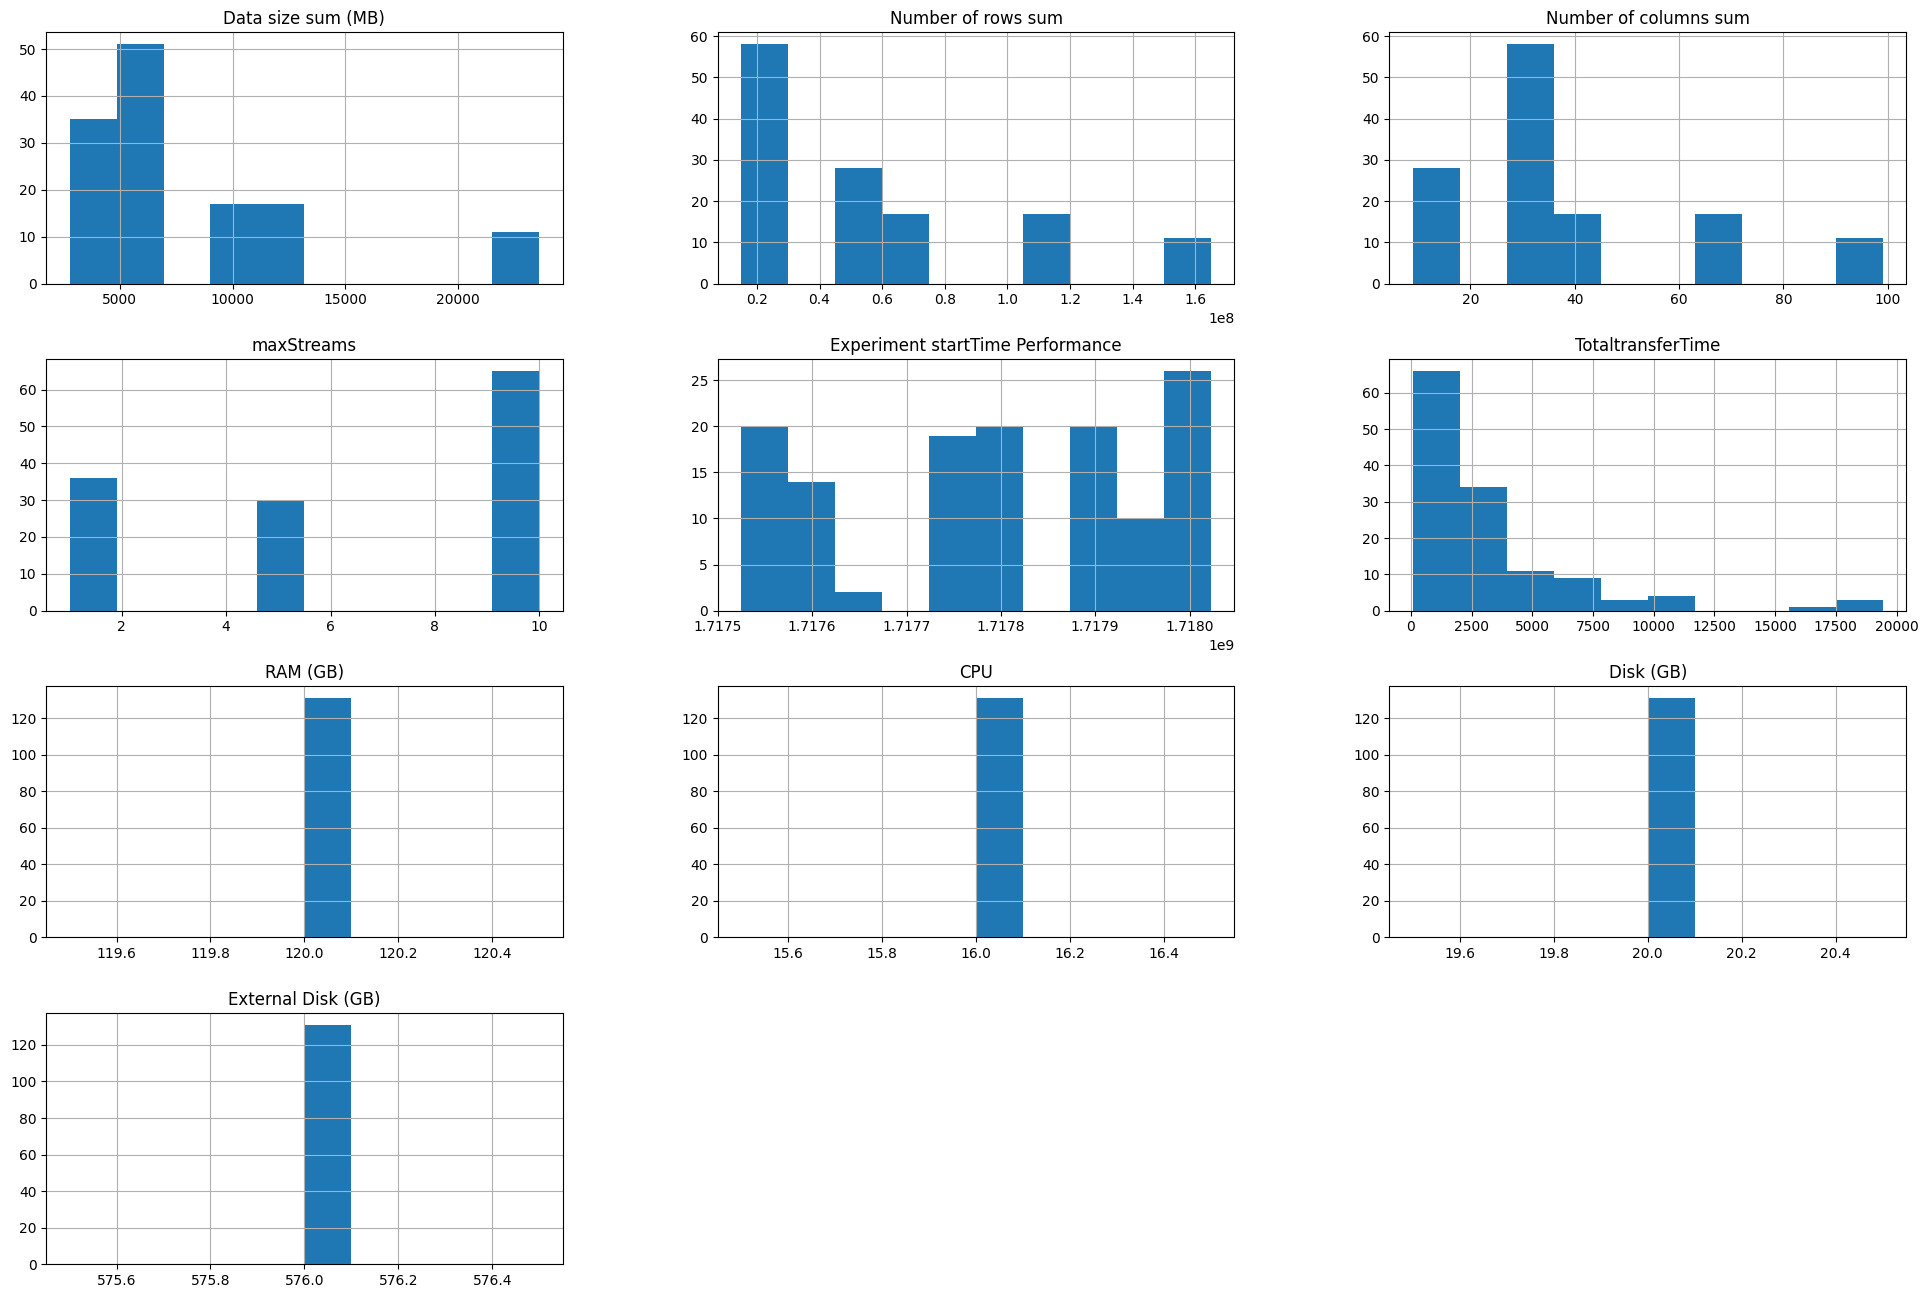

In [47]:
result_df.hist(figsize=(24, 16))
plt.show()

## 3.4 Pairwise corrolation using sns

In [48]:
# sns.pairplot(result_df)

In [49]:
print(type(result_df))


<class 'pandas.core.frame.DataFrame'>


# 3. Preprocessing 

### 3.1 Create a pipleline

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [51]:
# Create the cat and num columns
# Get a list of column names from the 'result_df' DataFrame that are of numerical data types.
# Get a list of column names from the 'result_df' DataFrame that are not of numerical data types.

num_cols = result_df.select_dtypes(include='number').columns.to_list()
cat_cols = result_df.select_dtypes(exclude='number').columns.to_list()

print(num_cols)

print(cat_cols)

# Exclude the target from numerical columns
num_cols.remove("TotaltransferTime")

# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# Use ColumnTransformer to set the estimators and transformations

preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

['Data size sum (MB)', 'Number of rows sum', 'Number of columns sum', 'maxStreams', 'Experiment startTime Performance', 'TotaltransferTime', 'RAM (GB)', 'CPU', 'Disk (GB)', 'External Disk (GB)']
['compress', 'binary']


Display the pipeline

In [52]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Data size sum (MB)', 'Number of rows sum',
                                  'Number of columns sum', 'maxStreams',
                                  'Experiment startTime Performance',
                                  'RAM (GB)', 'CPU', 'Disk (GB)',
                                  'External Disk (GB)']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['compress', 'binary'])])

In [53]:
# Apply the preprocessing pipeline on the dataset

result_df_prepared = preprocessing.fit_transform(result_df)

# Scikit-learn strips the column headers, so just add them back on afterward.
feature_names = preprocessing.get_feature_names_out()
result_df_prepared = pd.DataFrame(data=result_df_prepared, columns=feature_names)

result_df_prepared

,num__Data size sum (MB),num__Number of rows sum,num__Number of columns sum,num__maxStreams,num__Experiment startTime Performance,num__RAM (GB),num__CPU,num__Disk (GB),num__External Disk (GB),cat__compress_GZIP,cat__compress_LZ4,cat__compress_NO,cat__binary_False,remainder__TotaltransferTime
0,-0.873887,-0.728844,-0.118917,-1.394550,-1.664517,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3266.620216
1,-0.873887,-0.728844,-0.118917,-1.394550,-1.664517,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,588.320576
2,-0.873887,-0.728844,-0.118917,-1.394550,-1.664517,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1920.935266
3,-0.873887,-0.728844,-0.118917,-1.394550,-1.664517,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3783.924402
4,-0.873887,-0.728844,-0.118917,-1.394550,-1.664517,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1901.642637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,-0.436154,-0.862067,-0.405130,0.937613,1.390726,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,259.839403
127,-0.436154,-0.862067,-0.405130,0.937613,1.390726,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,320.256194
128,-0.436154,-0.862067,-0.405130,0.937613,1.390726,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,308.434418
129,-0.436154,-0.862067,-0.405130,0.937613,1.390726,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,322.706327


# 4. Selecting model and training

### 4.1 Split the dataset into a training dataset (80%) and testing dataset.

In [54]:
from sklearn.model_selection import train_test_split

# Splitting data into features and target variable
X = result_df_prepared.drop(["remainder__TotaltransferTime"], axis=1)
y = result_df_prepared["remainder__TotaltransferTime"]

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(104, 13) (104,) (27, 13) (27,)


In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    report = {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R² Score": r2
    }

    for metric, value in report.items():
        print(f"{metric}: {value:.4f}")

    return {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R² Score": r2
    }

### 4.2 Train a Linear Regression model with no regularization

In [56]:
# Dictionary to store the reports
reports = {}
feature_importances = {}

In [57]:
# Fitting the model
from sklearn.linear_model import LinearRegression


lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

lr_y_predict = lr_model.predict(X_test)

print("Linear Regressoin Report:")
reports["Linear Regression"] = regression_report(y_test, lr_y_predict)
# Pad the Linear Regression coefficients to match feature length
lr_importances = np.zeros(len(feature_names))
lr_importances[:len(lr_model.coef_)] = np.abs(lr_model.coef_)
feature_importances["Linear Regression"] = lr_importances

Linear Regressoin Report:
Mean Absolute Error (MAE): 1584.2892
Mean Squared Error (MSE): 5299145.6970
Root Mean Squared Error (RMSE): 2301.9873
R² Score: 0.6776


### 4.3 Decision Tree

In [58]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Regressor Report:")
reports["Decision Tree"] = regression_report(y_test, y_pred_dt)
# Pad the Decision Tree feature importances to match feature length
dt_importances = np.zeros(len(feature_names))
dt_importances[:len(dt_model.feature_importances_)] = dt_model.feature_importances_
feature_importances["Decision Tree"] = dt_importances

Decision Tree Regressor Report:
Mean Absolute Error (MAE): 879.4319
Mean Squared Error (MSE): 3385520.2201
Root Mean Squared Error (RMSE): 1839.9783
R² Score: 0.7940


### 4.4 Random Forest

In [59]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Regressor Report:")
reports["Random Forest"] = regression_report(y_test, y_pred_rf)
# Pad the Random Forest feature importances to match feature length
rf_importances = np.zeros(len(feature_names))
rf_importances[:len(rf_model.feature_importances_)] = rf_model.feature_importances_
feature_importances["Random Forest"] = rf_importances

Random Forest Regressor Report:
Mean Absolute Error (MAE): 876.3921
Mean Squared Error (MSE): 3209704.7350
Root Mean Squared Error (RMSE): 1791.5649
R² Score: 0.8047


### 4.5 Gradient Boosting

In [60]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42)

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("Gradient Boosting Regressor Report:")
reports["Gradient Boosting"] = regression_report(y_test, y_pred_gb)
# Pad the Gradient Boosting feature importances to match feature length
gb_importances = np.zeros(len(feature_names))
gb_importances[:len(gb_model.feature_importances_)] = gb_model.feature_importances_
feature_importances["Gradient Boosting"] = gb_importances

Gradient Boosting Regressor Report:
Mean Absolute Error (MAE): 866.3761
Mean Squared Error (MSE): 3380743.4036
Root Mean Squared Error (RMSE): 1838.6798
R² Score: 0.7943


### 4.6 Neural Network

In [62]:
# Neural Network
from sklearn.neural_network import MLPRegressor

nn_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train)

y_pred_nn = nn_model.predict(X_test)

print("Neural Network Regressor Report:")
reports["Neural Network"] = regression_report(y_test, y_pred_nn)
# Neural Networks do not have built-in feature importances. Feature importances can be computed using techniques like permutation importance or SHAP values.


Neural Network Regressor Report:
Mean Absolute Error (MAE): 2400.1635
Mean Squared Error (MSE): 19290645.9620
Root Mean Squared Error (RMSE): 4392.1118
R² Score: -0.1736


c:\Users\hasti\anaconda3\envs\DMBenchML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


### 4.7 XGBoost

In [63]:
# XGBoost
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Regressor Report:")
reports["XGBoost"] = regression_report(y_test, y_pred_xgb)
# Pad the XGBoost feature importances to match feature length
xgb_importances = np.zeros(len(feature_names))
xgb_importances[:len(xgb_model.feature_importances_)] = xgb_model.feature_importances_
feature_importances["XGBoost"] = xgb_importances

XGBoost Regressor Report:
Mean Absolute Error (MAE): 879.4315
Mean Squared Error (MSE): 3385519.8928
Root Mean Squared Error (RMSE): 1839.9782
R² Score: 0.7940


In [64]:
# Convert the reports dictionary to a DataFrame
reports_df = pd.DataFrame.from_dict(reports, orient='index')

# Save the DataFrame to a CSV file
reports_df.to_csv("model_performance_reports.csv", index=True)

In [65]:
# Save feature importances to a CSV file
feature_importances_df = pd.DataFrame(feature_importances, index=feature_names)
feature_importances_df.to_csv("feature_importances.csv", index=True)

In [66]:
print(reports)

{'Linear Regression': {'Mean Absolute Error (MAE)': 1584.2891557524335, 'Mean Squared Error (MSE)': 5299145.69695412, 'Root Mean Squared Error (RMSE)': 2301.987336401771, 'R² Score': 0.6776018459604176}, 'Decision Tree': {'Mean Absolute Error (MAE)': 879.4319131072657, 'Mean Squared Error (MSE)': 3385520.220126197, 'Root Mean Squared Error (RMSE)': 1839.9783205587498, 'R² Score': 0.7940261446180394}, 'Random Forest': {'Mean Absolute Error (MAE)': 876.3920985184278, 'Mean Squared Error (MSE)': 3209704.7350037717, 'Root Mean Squared Error (RMSE)': 1791.5648843968147, 'R² Score': 0.8047226966844647}, 'Gradient Boosting': {'Mean Absolute Error (MAE)': 866.3761315859816, 'Mean Squared Error (MSE)': 3380743.403634268, 'Root Mean Squared Error (RMSE)': 1838.6797991043106, 'R² Score': 0.7943167644475846}, 'Neural Network': {'Mean Absolute Error (MAE)': 2400.163544699313, 'Mean Squared Error (MSE)': 19290645.961977005, 'Root Mean Squared Error (RMSE)': 4392.111788419895, 'R² Score': -0.17363609